In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from joblib import dump, load

In [2]:
sns.set_style("whitegrid")

In [3]:
X_train = np.load("data/with_outliers_and_uncorrelated/X_train.npy")
X_val = np.load("data/with_outliers_and_uncorrelated/X_val.npy")
y_train = np.load("data/with_outliers_and_uncorrelated/y_train.npy")
y_val = np.load("data/with_outliers_and_uncorrelated/y_val.npy")
X_test = np.load("data/with_outliers_and_uncorrelated/X_test.npy")

In [4]:
def model_train_and_tune(model, param_grid, X_train, y_train, random_search=False):
    if random_search:
        grid_search = RandomizedSearchCV(model, param_grid, cv=5, scoring="roc_auc_ovr", n_jobs=-1, verbose=2)
    else:
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring="roc_auc_ovr", n_jobs=-1, verbose=2)

    grid_search.fit(X_train, y_train)

    return grid_search.best_score_, grid_search.best_params_, grid_search.best_estimator_

In [5]:
def print_results(score, params):
    print(f"Best score: {score}")
    print(f"Best params: {params}")

In [6]:
def custom_auc_score(y_true, y_pred_prob):
    roc_auc_scores = []
    for i in range(y_pred_prob.shape[1]):
        y_true_i = np.where(y_true == i, 1, 0)
        roc_auc_scores.append(roc_auc_score(y_true_i, y_pred_prob[:, i]))
    return np.mean(roc_auc_scores)

In [7]:
weights = {
    0: 19219 / 4761 / 8,
    1: 19219 / 485 / 8,
    2: 19219 / 3431 / 8,
    3: 19219 / 818 / 8,
    4: 19219 / 6540 / 8,
    5: 19219 / 1466 / 8,
    6: 19219 / 568 / 8,
    7: 19219 / 1150 / 8
}

In [13]:
lr_model = LogisticRegression(class_weight=weights)
param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "penalty": ["l1", "l2", "elasticnet", "none"],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
}
lr_score, lr_params, lr_model = model_train_and_tune(lr_model, param_grid, X_train, y_train)

Fitting 5 folds for each of 140 candidates, totalling 700 fits


c:\Users\ivan.trujillo_blueta\proyectos\personal\steel_plate_defect\venv\lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
455 fits failed out of a total of 700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ivan.trujillo_blueta\proyectos\personal\steel_plate_defect\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ivan.trujillo_blueta\proyectos\personal\steel_plate_defect\venv\lib\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\ivan.t

In [14]:
print_results(lr_score, lr_params)

Best score: 0.8341807240568251
Best params: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


In [22]:
roc_auc_score(y_val, lr_model.predict_proba(X_val), multi_class="ovr")

0.8361684498871582

In [27]:
custom_auc_score(y_val, lr_model.predict_proba(X_val))

0.8361684498871582

In [16]:
rf_model = RandomForestClassifier(class_weight=weights)
param_grid = {
    "n_estimators": [200, 300],
    "max_depth": [10, 50, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
rf_score, rf_params, rf_model = model_train_and_tune(rf_model, param_grid, X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [17]:
print_results(rf_score, rf_params)

Best score: 0.849712017983889
Best params: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}


In [28]:
roc_auc_score(y_val, rf_model.predict_proba(X_val), multi_class="ovr")

0.8522411944813675

In [29]:
custom_auc_score(y_val, rf_model.predict_proba(X_val))

0.8522411944813675

In [33]:
xgb_model = xgb.XGBClassifier(scale_pos_weight=weights)
param_grid = {
    "n_estimators": [300, 500],
    "max_depth": [10, 50, None],
    "learning_rate": [0.001, 0.01, 0.1],
    "subsample": [0.5, 0.7, 1.0]
}
xgb_score, xgb_params, xgb_model = model_train_and_tune(xgb_model, param_grid, X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


c:\Users\ivan.trujillo_blueta\proyectos\personal\steel_plate_defect\venv\lib\site-packages\xgboost\core.py:160: UserWarning: [12:43:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


In [34]:
print_results(xgb_score, xgb_params)

Best score: 0.8578062056469516
Best params: {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 500, 'subsample': 0.5}


In [35]:
roc_auc_score(y_val, xgb_model.predict_proba(X_val), multi_class="ovr")

0.8595498097646759

In [37]:
lightgbm_model = lgb.LGBMClassifier(class_weight=weights)
param_grid = {
    "n_estimators": [300, 500],
    "max_depth": [10, 50, None],
    "learning_rate": [0.001, 0.01, 0.1],
    "subsample": [0.5, 0.7, 1.0]
}
lightgbm_score, lightgbm_params, lightgbm_model = model_train_and_tune(lightgbm_model, param_grid, X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4683
[LightGBM] [Info] Number of data points in the train set: 15375, number of used features: 24
[LightGBM] [Info] Start training from score -2.076621
[LightGBM] [Info] Start training from score -2.053538
[LightGBM] [Info] Start training from score -2.082468
[LightGBM] [Info] Start training from score -2.114091
[LightGBM] [Info] Start training from score -2.091864
[LightGBM] [Info] Start training from score -2.090670
[LightGBM] [Info] Start training from score -2.054507
[LightGBM] 

In [38]:
print_results(lightgbm_score, lightgbm_params)

Best score: 0.8517178592509358
Best params: {'learning_rate': 0.01, 'max_depth': 50, 'n_estimators': 500, 'subsample': 0.5}


In [39]:
roc_auc_score(y_val, lightgbm_model.predict_proba(X_val), multi_class="ovr")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


0.8554760812902763

In [8]:
catboost_model = cb.CatBoostClassifier(class_weights=weights)
param_grid = {
    "n_estimators": [300, 500],
    "max_depth": [3, 5, 10],
    "learning_rate": [0.001, 0.01, 0.1],
}
catboost_score, catboost_params, catboost_model = model_train_and_tune(catboost_model, param_grid, X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
0:	learn: 1.9053898	total: 146ms	remaining: 43.8s
1:	learn: 1.7948948	total: 158ms	remaining: 23.6s
2:	learn: 1.7195512	total: 169ms	remaining: 16.7s
3:	learn: 1.6554646	total: 180ms	remaining: 13.3s
4:	learn: 1.6065876	total: 190ms	remaining: 11.2s
5:	learn: 1.5574440	total: 201ms	remaining: 9.85s
6:	learn: 1.5248258	total: 212ms	remaining: 8.86s
7:	learn: 1.4940541	total: 223ms	remaining: 8.12s
8:	learn: 1.4665913	total: 234ms	remaining: 7.55s
9:	learn: 1.4418134	total: 245ms	remaining: 7.09s
10:	learn: 1.4205312	total: 256ms	remaining: 6.72s
11:	learn: 1.3962892	total: 267ms	remaining: 6.41s
12:	learn: 1.3728444	total: 278ms	remaining: 6.15s
13:	learn: 1.3575626	total: 290ms	remaining: 5.92s
14:	learn: 1.3372734	total: 302ms	remaining: 5.74s
15:	learn: 1.3201631	total: 314ms	remaining: 5.57s
16:	learn: 1.3022637	total: 326ms	remaining: 5.42s
17:	learn: 1.2898148	total: 337ms	remaining: 5.27s
18:	learn: 1.2740485	total: 349

In [9]:
print_results(catboost_score, catboost_params)

Best score: 0.8527492967012437
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}


In [10]:
roc_auc_score(y_val, catboost_model.predict_proba(X_val), multi_class="ovr")

0.8545405267789975

In [16]:
xgboost_model_stack = xgb.XGBClassifier(class_weight=weights, learning_rate=0.01, max_depth=None, n_estimators=500, subsample=0.5)
rf_model_stack = RandomForestClassifier(class_weight=weights, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=300)
lightgbm_model_stack = lgb.LGBMClassifier(class_weight=weights, learning_rate=0.01, max_depth=50, n_estimators=500, subsample=0.5)
catboost_model_stack = cb.CatBoostClassifier(class_weights=weights, learning_rate=0.1, max_depth=5, n_estimators=300)
final_model = xgb.XGBClassifier(class_weight=weights, learning_rate=0.01, max_depth=None, n_estimators=500, subsample=0.5)

In [17]:
stacking_model = StackingClassifier(
    estimators=[
        ("XGBoost", xgboost_model_stack),
        ("LightGBM", lightgbm_model_stack),
        ("CatBoost", catboost_model_stack),
        ("Random_forest", rf_model_stack)
    ],
    final_estimator=final_model
)

In [20]:
stacking_model.fit(X_train, y_train)

c:\Users\ivan.trujillo_blueta\proyectos\personal\steel_plate_defect\venv\lib\site-packages\xgboost\core.py:160: UserWarning: [14:47:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4683
[LightGBM] [Info] Number of data points in the train set: 15375, number of used features: 24
[LightGBM] [Info] Start training from score -2.076621
[LightGBM] [Info] Start training from score -2.053538
[LightGBM] [Info] Start training from score -2.082468
[LightGBM] [Info] Start training from score -2.114091
[LightGBM] [Info] Start training from score -2.091864
[LightGBM] [Info] Start training from score -2.090670
[LightGBM] [Info] Start training from score -2.054507
[LightGBM

c:\Users\ivan.trujillo_blueta\proyectos\personal\steel_plate_defect\venv\lib\site-packages\xgboost\core.py:160: UserWarning: [14:47:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.trujillo_blueta\proyectos\personal\steel_plate_defect\venv\lib\site-packages\xgboost\core.py:160: UserWarning: [14:47:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\ivan.trujillo_blueta\proyectos\personal\steel_plate_defect\venv\lib\site-packages\xgboost\core.py:160: UserWarning: [14:47:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:7

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4664
[LightGBM] [Info] Number of data points in the train set: 12300, number of used features: 24
[LightGBM] [Info] Start training from score -2.076677
[LightGBM] [Info] Start training from score -2.053725
[LightGBM] [Info] Start training from score -2.082746
[LightGBM] [Info] Start training from score -2.114278
[LightGBM] [Info] Start training from score -2.092244
[LightGBM] [Info] Start training from score -2.090857
[LightGBM] [Info] Start training from score -2.053092
[LightGBM] [Info] Start training from score -2.073373
[LightGBM] [Warning

c:\Users\ivan.trujillo_blueta\proyectos\personal\steel_plate_defect\venv\lib\site-packages\xgboost\core.py:160: UserWarning: [14:49:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


StackingClassifier(estimators=[('XGBoost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              class_weight={0: 0.5045946229783659,
                                                            1: 4.953350515463917,
                                                            2: 0.7001967356455844,
                                                            3: 2.936888753056235,
                                                            4: 0.367335626911315,
                                                            5: 1.6387278308321964,
                                                            6: 4.229533450704225,
                                                            7: 2.089021739130435},
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              devic...
                                                 feature_types=None, gamma=None,
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.01,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=500, n_jobs=None,
                                                 num_parallel_tree=None, ...))

In [21]:
stacking_model.score(X_val, y_val)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


0.5840270551508845

In [22]:
roc_auc_score(y_val, stacking_model.predict_proba(X_val), multi_class="ovr")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


0.8591717619299829

In [25]:
xgb_model_2 = xgb.XGBClassifier(learning_rate=0.01, max_depth=None, n_estimators=500, subsample=0.5)
xgb_model_2.fit(X_train, y_train)

c:\Users\ivan.trujillo_blueta\proyectos\personal\steel_plate_defect\venv\lib\site-packages\xgboost\core.py:160: UserWarning: [14:56:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight={0: 0.5045946229783659, 1: 4.953350515463917,
                            2: 0.7001967356455844, 3: 2.936888753056235,
                            4: 0.367335626911315, 5: 1.6387278308321964,
                            6: 4.229533450704225, 7: 2.089021739130435},
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_c...s=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

In [26]:
roc_auc_score(y_val, xgb_model_2.predict_proba(X_val), multi_class="ovr")

0.8595498097646759

In [28]:
from sklearn.utils.class_weight import compute_sample_weight
xgb_model_3 = xgb.XGBClassifier(learning_rate=0.01, max_depth=None, n_estimators=500, subsample=0.5)
xgb_model_3.fit(X_train, y_train, sample_weight=compute_sample_weight("balanced", y_train))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [29]:
roc_auc_score(y_val, xgb_model_3.predict_proba(X_val), multi_class="ovr")

0.8560042503663587

In [30]:
f1_score(y_val, xgb_model_2.predict(X_val), average="weighted")

0.5609640452468763

<Axes: >

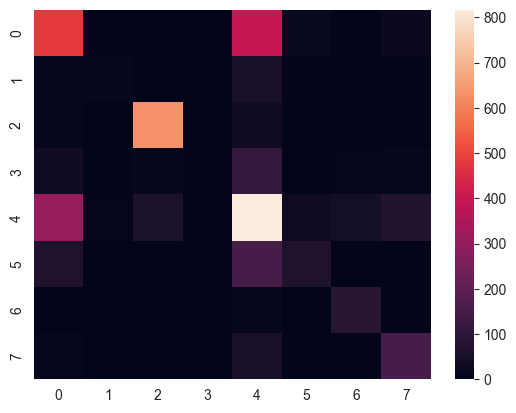

In [32]:
sns.heatmap(confusion_matrix(y_val, xgb_model_2.predict(X_val)))

In [47]:
class_rep = classification_report(
    y_val,
    xgb_model_2.predict(X_val),
    labels=[0, 1, 2, 3, 4, 5, 6, 7],
    target_names=["Bumps", "Dirtiness", "K_Scatch", "No_Defect", "Other_Faults", "Pastry", "Stains", "Z_Scratch"],
    output_dict=True
)

<Axes: >

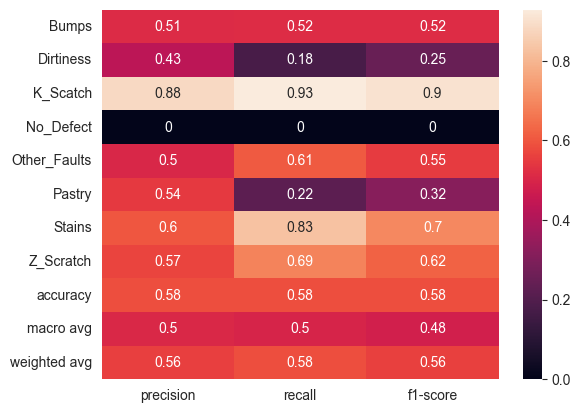

In [48]:
sns.heatmap(pd.DataFrame(class_rep).iloc[:-1, :].T, annot=True)

In [34]:
test_pd = pd.read_csv('data/test.csv')

In [37]:
y_pred_test = xgb_model_2.predict_proba(X_test)

In [38]:
y_pred_test

array([[0.13964856, 0.02085515, 0.00858611, ..., 0.437327  , 0.00813922,
        0.00896302],
       [0.15667655, 0.16306444, 0.02175563, ..., 0.23980644, 0.00921766,
        0.02008741],
       [0.26940107, 0.01490926, 0.04479392, ..., 0.01054761, 0.01025022,
        0.05238574],
       ...,
       [0.00432065, 0.00471957, 0.9141269 , ..., 0.00432498, 0.00413335,
        0.00451048],
       [0.13568528, 0.06165341, 0.03522565, ..., 0.33704656, 0.00870587,
        0.02443151],
       [0.00391494, 0.00493038, 0.8970668 , ..., 0.00479132, 0.0037353 ,
        0.01113612]], dtype=float32)

In [40]:
result = pd.concat([test_pd['id'], pd.DataFrame(y_pred_test, columns=["Bumps", "Dirtiness", "K_Scatch", "No_Defect", "Other_Faults", "Pastry", "Stains", "Z_Scratch"])], axis=1)

In [41]:
result

,id,Bumps,Dirtiness,K_Scatch,No_Defect,Other_Faults,Pastry,Stains,Z_Scratch
0,19219,0.139649,0.020855,0.008586,0.035796,0.340685,0.437327,0.008139,0.008963
1,19220,0.156677,0.163064,0.021756,0.046081,0.343311,0.239806,0.009218,0.020087
2,19221,0.269401,0.014909,0.044794,0.067541,0.530172,0.010548,0.010250,0.052386
3,19222,0.374654,0.020177,0.008314,0.028936,0.419711,0.129634,0.008866,0.009708
4,19223,0.601213,0.013474,0.007870,0.035450,0.316472,0.009413,0.007924,0.008183
...,...,...,...,...,...,...,...,...,...
12809,32028,0.301876,0.040240,0.011492,0.089324,0.373056,0.071011,0.010797,0.102206
12810,32029,0.140332,0.143309,0.038482,0.039837,0.423498,0.180554,0.019890,0.014099
12811,32030,0.004321,0.004720,0.914127,0.020562,0.043302,0.004325,0.004133,0.004510
12812,32031,0.135685,0.061653,0.035226,0.071363,0.325888,0.337047,0.008706,0.024432


In [42]:
result = result.drop("No_Defect", axis=1)

In [43]:
result.to_csv('data/with_outliers_and_uncorrelated/result_with_outliers_and_uncorrelated.csv', index=False)

In [45]:
dump(xgb_model_2, 'models/with_outliers_and_uncorrelated/xgb_model.joblib')

['models/with_outliers_and_uncorrelated/xgb_model.joblib']